# Exploratory Data Analysis (EDA) - Xente Credit Risk Model

## 1. Introduction
This notebook performs a structured Exploratory Data Analysis (EDA) on the Xente transaction dataset. The goal is to understand the data quality, distributions, and potential risk indicators before proceeding to feature engineering and modeling.

**Objectives:**
- Load and inspect data structure.
- Identify missing values and outliers.
- Analyze distributions of monetary and categorical features.
- Explore correlations between numerical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set professional plot style
sns.set_theme(style='whitegrid', context='notebook', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

## 2. Load Data
We automatically detect and load the transaction CSV file from the `data/raw/` directory.

In [2]:
data_dir = '../data/raw/'
files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and 'data' in f.lower()]

if files:
    file_path = os.path.join(data_dir, files[0])
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Dataset Shape: {df.shape}")
    display(df.head())
else:
    raise FileNotFoundError("No CSV file found in data/raw/")

Loading data from: ../data/raw/data.csv


Dataset Shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


## 3. Data Structure & Types
Inspecting column data types and non-null counts to understand the schema.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

## 4. Summary Statistics
Descriptive statistics for numerical columns help identify scale, central tendency, and potential skewness.

In [4]:
display(df.describe())

# Skewness analysis
skew_cols = ['Amount', 'Value']
for col in skew_cols:
    if col in df.columns:
        print(f"Skewness of {col}: {df[col].skew():.2f}")

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


Skewness of Amount: 51.10
Skewness of Value: 51.29


## 5. Missing Values Analysis
Identifying columns with missing data is crucial for determining imputation strategies.

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing.index, y=missing.values, palette='viridis')
    plt.title('Missing Values Count per Column')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    display(missing)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


## 6. Numerical Distributions
Visualizing the distribution of key monetary features. A log scale is applied if data is highly skewed.

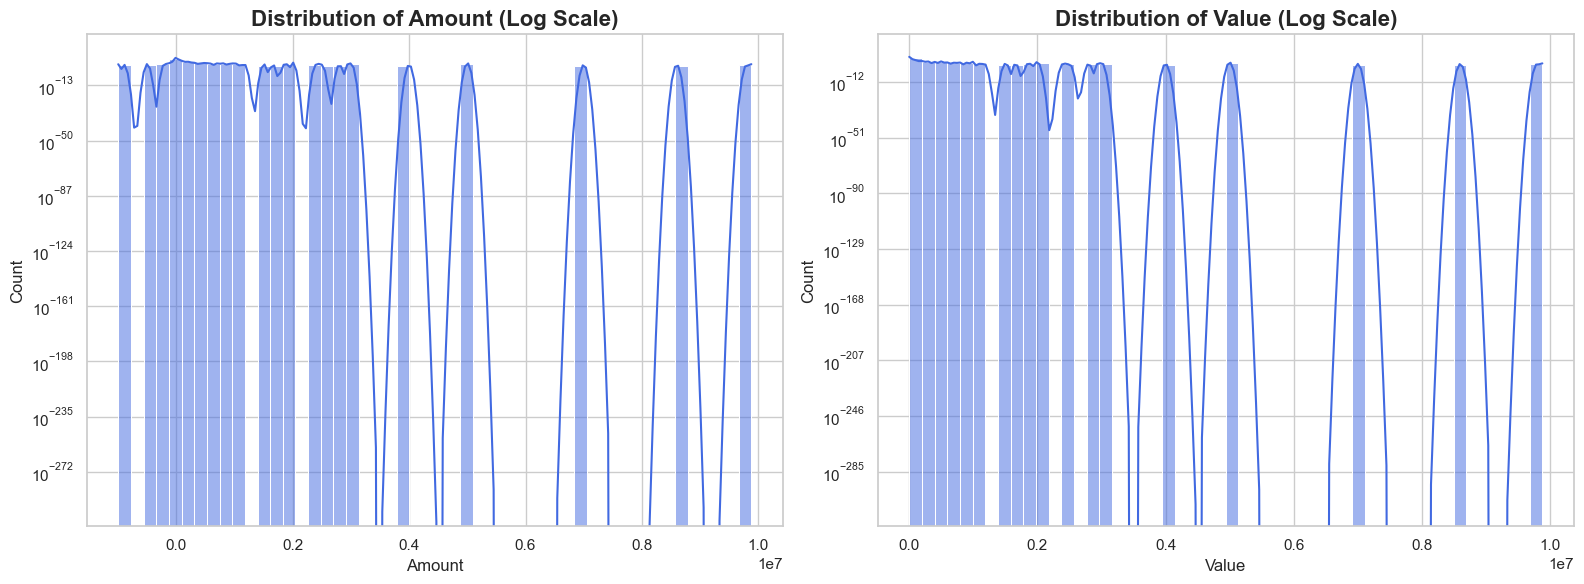

In [6]:
num_cols = [c for c in ['Amount', 'Value'] if c in df.columns]

if num_cols:
    fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 6))
    if len(num_cols) == 1: axes = [axes]
    
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='royalblue')
        axes[i].set_title(f'Distribution of {col} (Log Scale)', fontweight='bold')
        axes[i].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

## 7. Categorical Analysis
Examining the frequency of top categories in `ProductCategory` and `ChannelId`.

C:\Users\hp\AppData\Local\Temp\ipykernel_12804\857267100.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')
C:\Users\hp\AppData\Local\Temp\ipykernel_12804\857267100.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')


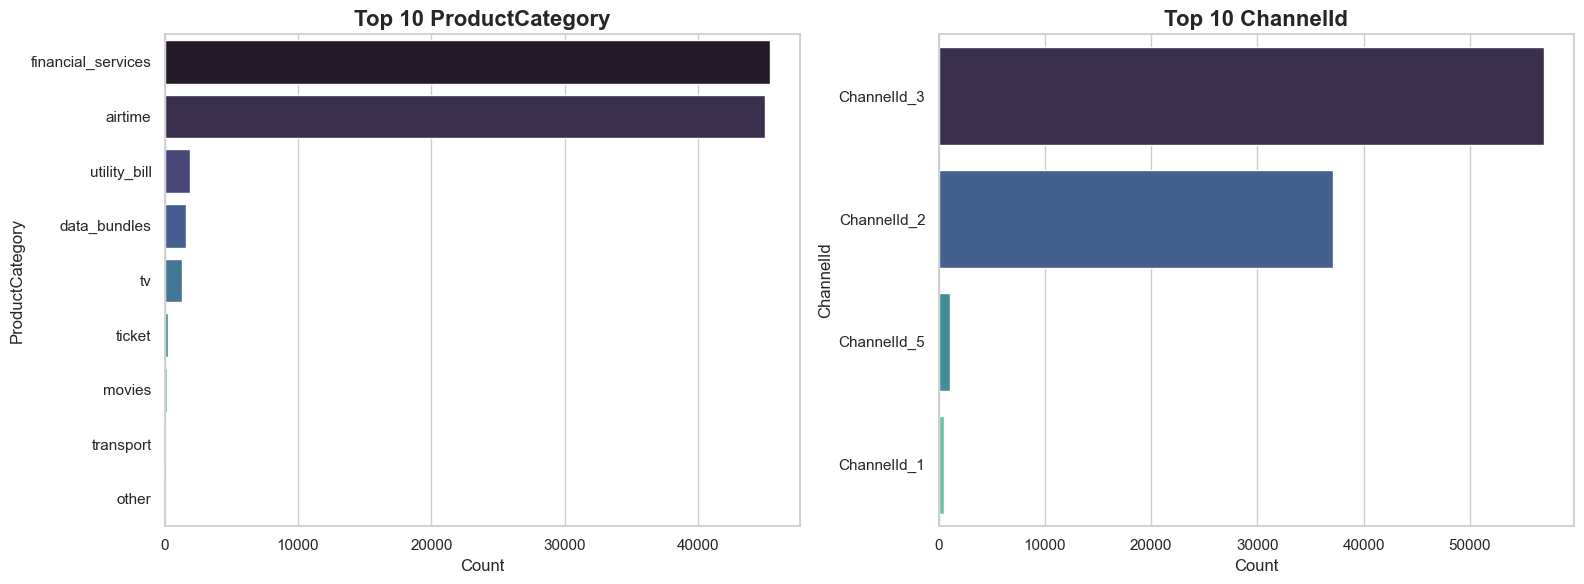

In [7]:
cat_cols = ['ProductCategory', 'ChannelId']
present_cat = [c for c in cat_cols if c in df.columns]

if present_cat:
    fig, axes = plt.subplots(1, len(present_cat), figsize=(16, 6))
    if len(present_cat) == 1: axes = [axes]

    for i, col in enumerate(present_cat):
        top_10 = df[col].value_counts().head(10)
        sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i], palette='mako')
        axes[i].set_title(f'Top 10 {col}', fontweight='bold')
        axes[i].set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()

## 8. Correlation Analysis
Analyzing relationships between numerical variables using a heatmap.

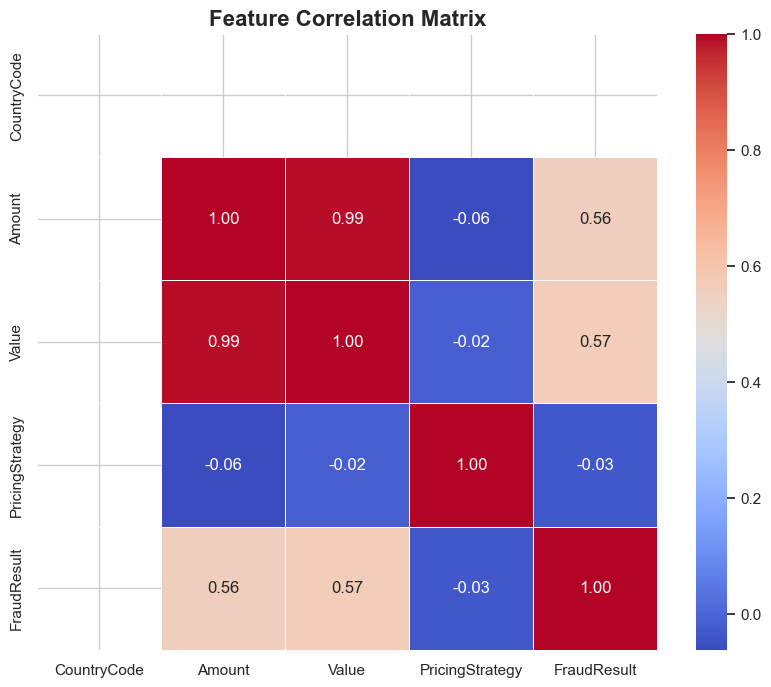

In [8]:
numeric_df = df.select_dtypes(include=[np.number])
if not numeric_df.empty:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontweight='bold')
    plt.show()

## 9. Outlier Detection
Using boxplots to visually inspect potential outliers in the `Amount` feature.

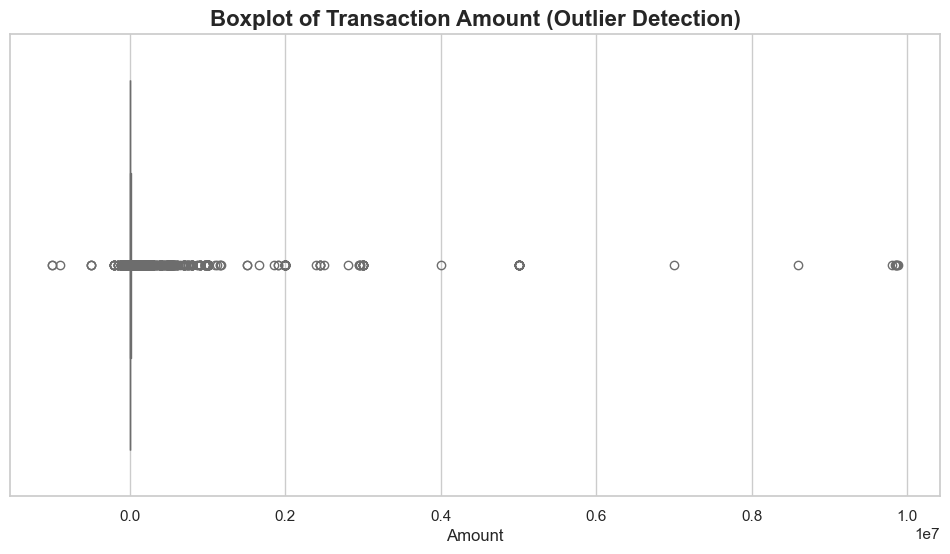

In [9]:
if 'Amount' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['Amount'], color='salmon')
    plt.title('Boxplot of Transaction Amount (Outlier Detection)', fontweight='bold')
    plt.xlabel('Amount')
    plt.show()